<font size="5">Analyse zur Erreichbarkeit (Wegstrecke) der Zürcher Recycling-Sammelstellen</font>

References:

- Datensatz 'Standorte der Wertstoffsammelstellen (Glas, Kleinmetall, Altöl und Textilien) in der Stadt Zürich' der Stadt Zürich, https://www.stadt-zuerich.ch/geodaten/download/Sammelstelle

- Datensatz 'Adressen Stadt Zürich' der Stadt Zürich, https://www.stadt-zuerich.ch/geodaten/download/Adressen_Stadt_Zuerich

In [2]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import googlemaps
import requests

In [ ]:
# Functions

def save_numpy_array(np_arr,SAVEFILE_NAME):
    # This function stores the numpy array in the current directory
    with open('./{}.npy'.format(SAVEFILE_NAME), 'wb') as f:
        np.save(f, np_arr)
    return()

def load_numpy_array(SAVEFILE_NAME):
    # This function loads the numpy array from the current directory
    with open('./{}.npy'.format(SAVEFILE_NAME), 'rb') as f:
        return(np.load(f)) 
    
def convert_coordinates(koord_df,SAVEFILE_NAME):
    # This function converts vl95 coordinates to wgs84 coordinates using an API from swisstopo
    import os

    if os.path.exists('./{}.npy'.format(SAVEFILE_NAME)):
        koord_df_wgs84 = load_numpy_array(SAVEFILE_NAME)

    else:
        koord_df_wgs84 = np.empty(koord_df.shape,dtype='float')
        for i in range(koord_df.shape[0]):

            api_url = 'http://geodesy.geo.admin.ch/reframe/lv95towgs84?easting={}&northing={}&altitude=550.0&format=json'.format(koord_df[i,1],koord_df[i,0])

            response = requests.get(api_url)
            koord_df_wgs84[i,0] = float(response.json()['easting'])
            koord_df_wgs84[i,1] = float(response.json()['northing'])

            save_numpy_array(koord_df_wgs84,SAVEFILE_NAME)
    return(koord_df_wgs84)

def batch(iterable, n=1):
    # This function slices iterables into slices/batches of size n
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

In [40]:
# Read dataset 'Sammelstellen'

PATH_SAMMELSTELLEN = '/Users/Derk/Desktop/DS Zürich/Sammelstellen/data/stzh.poi_sammelstelle_view.csv'
df_sammelstellen=pd.read_csv(PATH_SAMMELSTELLEN)

# Extract coordinates from field 'geometry'
df_sammelstellen["koord_ost"] = df_sammelstellen.geometry.str.extract(r'\s\((\d*\.?\d*)').astype('double')
df_sammelstellen["koord_nord"] = df_sammelstellen.geometry.str.extract(r'\s(\d{7,}\.?\d*)').astype('double')

#df_sammelstellen.head()

In [30]:
# Read dataset 'Adressen'

PATH_ADRESSEN = '/Users/Derk/Desktop/DS Zürich/Adressen/data/geoz.adrstzh_adressen_stzh_p.csv'
df_adressen=pd.read_csv(PATH_ADRESSEN)

# Rename coordinates
df_adressen.rename(columns={"hausnummer_koord_ost":"koord_ost","hausnummer_koord_nord":"koord_nord"},inplace=True)

#df_adressen.head()

In [ ]:
# For each address, find the index of the 'USE_N_NEAREST'-nearest (euclidean distance) 'sammelstellen', for each each of the 4 different 'RECYCLINGGÜTER'

USE_N_NEAREST = 3
RECYCLINGGÜTER = ['metall','glas','oel','textilien']

koord_adressen = df_adressen[['koord_nord','koord_ost']].to_numpy()
koord_sammelstellen = df_sammelstellen[['koord_nord','koord_ost']].to_numpy()

idx_nearest = np.empty([koord_adressen.shape[0],USE_N_NEAREST,len(RECYCLINGGÜTER)],dtype='int')

for r_i,r in enumerate(RECYCLINGGÜTER):
    koord_sammelstellen_subset = df_sammelstellen.loc[df_sammelstellen[r]=='X',['koord_nord','koord_ost']].to_numpy()
    koord_sammelstellen_subset_idx = df_sammelstellen.loc[df_sammelstellen[r]=='X'].index.values
    
    subset_idx_map = dict(zip(range(koord_sammelstellen_subset_idx.shape[0]),koord_sammelstellen_subset_idx))
    lin_dist_to_each_sammelstelle_subset = cdist(koord_adressen,koord_sammelstellen_subset)
    subset_idx_nearest = np.empty([lin_dist_to_each_sammelstelle_subset.shape[0],USE_N_NEAREST],dtype='int')

    for i in range(lin_dist_to_each_sammelstelle_subset.shape[0]):
        idx = np.argpartition(lin_dist_to_each_sammelstelle_subset[i,:], USE_N_NEAREST)
        subset_idx_nearest[i,:] = idx[:USE_N_NEAREST]

    sort_idx = np.argsort(list(subset_idx_map.keys()))
    idx = np.searchsorted(list(subset_idx_map.keys()),subset_idx_nearest,sorter = sort_idx)
    idx_nearest[:,:,r_i] = np.asarray(list(subset_idx_map.values()))[sort_idx][idx]

In [723]:
# Convert coordinates from LV95 to WGS84 (or load if already stored)

SAVEFILE_NAME = 'Koordinaten_Adressen_WGS84'
koord_adressen_wgs84 = convert_coordinates(koord_adressen,SAVEFILE_NAME)

SAVEFILE_NAME = 'Koordinaten_Sammelstellen_WGS84'
koord_sammelstellen_wgs84 = convert_coordinates(koord_sammelstellen,SAVEFILE_NAME)

In [690]:
# Find distance between all 'sammelstellen' and each address for which it belongs to the USE_N_NEAREST nearest 'sammelstellen'

API_KEY = *add api key here*
BATCH_SIZE = 25

durations = np.empty([koord_adressen_wgs84.shape[0],USE_N_NEAREST,len(RECYCLINGGÜTER)],dtype='int')
distances = np.empty([koord_adressen_wgs84.shape[0],USE_N_NEAREST,len(RECYCLINGGÜTER)],dtype='int')

# Iterate through all 'sammelstellen' and get distance to nearby homes using googlemaps API
for sammelstelle_ in range(koord_sammelstellen_wgs84.shape[0]):
    
    addr_idx_nearby = np.where(idx_nearest == sammelstelle_)
    
    str_origin = str(koord_sammelstellen_wgs84[sammelstelle_][1]) + "%2C" + str(koord_sammelstellen_wgs84[sammelstelle_][0])
    str_destinations = [str(koord_adressen_wgs84[addr_idx_nearby[0][i]][1]) + "%2C" + str(koord_adressen_wgs84[addr_idx_nearby[0][i]][0]) for i in range(len(idx_sammelstelle_isnear[0]))] #[:25]
    
    for b in batch(range(len(addr_idx_nearby[0])), BATCH_SIZE):
        
        str_destinations_batch = '%7C'.join([str_destinations[k] for k in b])
        api_url_google = "https://maps.googleapis.com/maps/api/distancematrix/json?origins={}&destinations={}&mode=walking&key={}".format(str_origin,str_destinations_batch,API_KEY)
        response = requests.request("GET", api_url_google, headers={}, data={})

        for idx_, adresse_ in enumerate(b):
            ad_ = addr_idx_nearby[0][adresse_]
            n_ = addr_idx_nearby[1][adresse_]
            r_ = addr_idx_nearby[2][adresse_]
            distances[ad_,n_,r_] = response.json()['rows'][0]['elements'][idx_]['distance']['value']

    print(np.round((sammelstelle_+1)/koord_sammelstellen_wgs84.shape[0]*100,2),"% done.")

0.56 % done.
1.12 % done.
1.68 % done.
2.23 % done.
2.79 % done.
3.35 % done.
3.91 % done.
4.47 % done.
5.03 % done.
5.59 % done.
6.15 % done.
6.7 % done.
7.26 % done.
7.82 % done.
8.38 % done.
8.94 % done.
9.5 % done.
10.06 % done.
10.61 % done.
11.17 % done.
11.73 % done.
12.29 % done.
12.85 % done.
13.41 % done.
13.97 % done.
14.53 % done.
15.08 % done.
15.64 % done.
16.2 % done.
16.76 % done.
17.32 % done.
17.88 % done.
18.44 % done.
18.99 % done.
19.55 % done.
20.11 % done.
20.67 % done.
21.23 % done.
21.79 % done.
22.35 % done.
22.91 % done.
23.46 % done.
24.02 % done.
24.58 % done.
25.14 % done.
25.7 % done.
26.26 % done.
26.82 % done.
27.37 % done.
27.93 % done.
28.49 % done.
29.05 % done.
29.61 % done.
30.17 % done.
30.73 % done.
31.28 % done.
31.84 % done.
32.4 % done.
32.96 % done.
33.52 % done.
34.08 % done.
34.64 % done.
35.2 % done.
35.75 % done.
36.31 % done.
36.87 % done.
37.43 % done.
37.99 % done.
38.55 % done.
39.11 % done.
39.66 % done.
40.22 % done.
40.78 % done.
4

In [725]:
# Store result locally

SAVEFILE_NAME = 'Results'
save_numpy_array(distances,SAVEFILE_NAME)

()

In [712]:
# Find closest 'sammelstelle' (of the nearby 'sammelstellen') for each address and for each of the 'RECYCLINGGÜTER'

for i_, recy_gut in enumerate(RECYCLINGGÜTER):
    min_distances = distances[:,:,i_].min(axis=1)
    min_distances = min_distances.clip(None,1500)
    df_adressen["distanz_naechste_sammelstelle_"+recy_gut] = min_distances.tolist()

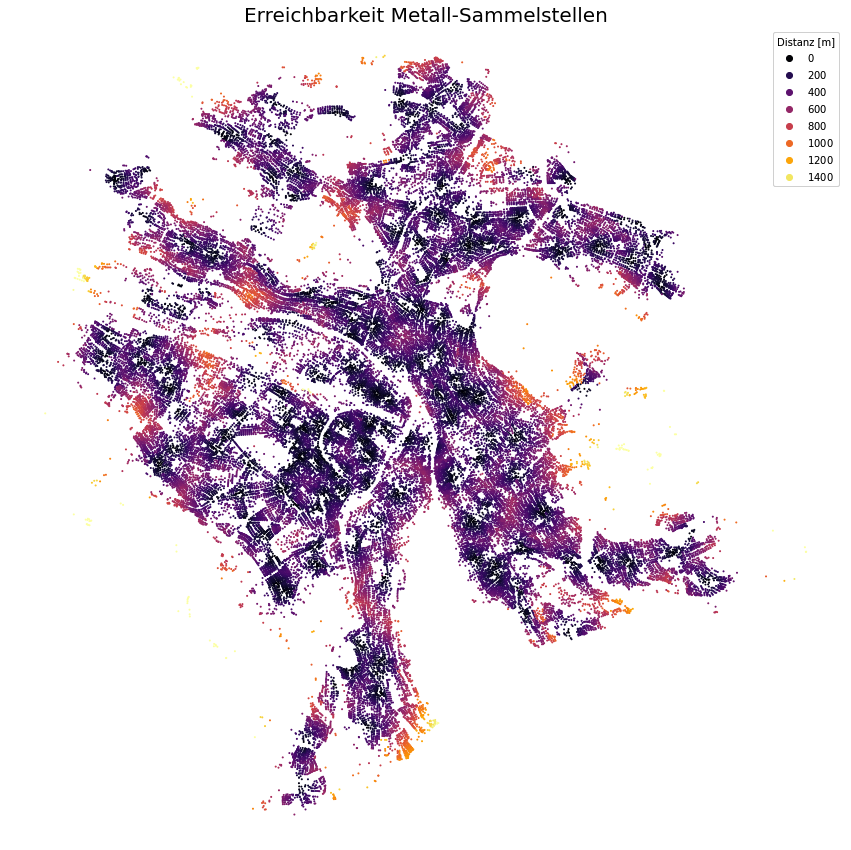

In [728]:
# Plot map

material_n = 0

fig, ax = plt.subplots(figsize=(15, 15))

scatt = ax.scatter(df_adressen["koord_ost"].values.tolist(),df_adressen["koord_nord"].values.tolist(),s=1,c=df_adressen["distanz_naechste_sammelstelle_"+RECYCLINGGÜTER[material_n]],cmap='inferno')
# 'summer' 'inferno' 'plasma' 'viridis' 'coolwarm'
ax.axis('equal')
ax.axis('off')

legend1 = ax.legend(*scatt.legend_elements(), loc="upper right", title="Distanz [m]")
ax.add_artist(legend1)

plt.title("Erreichbarkeit " + RECYCLINGGÜTER[material_n].capitalize() + "-Sammelstellen",fontsize=20)

plt.show()